# Deep Learning Term Project for ECG (DIL700)

# Iteration 3

## Imports

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
# # Original data

# train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
# test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# # Put together the training and testing
# full_df=pd.concat([train_df,test_df],ignore_index=True)

# Synthetic data

train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
train_df = train_df.iloc[:, :-1]
train_df.rename(columns={'class': 187}, inplace=True)
test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
test_df = test_df.iloc[:, :-1]
test_df.rename(columns={'class': 187}, inplace=True)

# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df = train_df[train_df[187] != '3.0']
test_df = test_df[test_df[187] != '3.0']
full_df = full_df[full_df[187] != '3.0']

train_df = train_df[train_df[187] != 'class']
test_df = test_df[test_df[187] != 'class']
full_df = full_df[full_df[187] != 'class']

train_df.loc[train_df[187] == 4, 187] = 3.0
test_df.loc[test_df[187] == 4, 187] = 3.0
full_df.loc[full_df[187] == 4, 187] = 3.0

train_df.loc[train_df[187] == '4.0', 187] = 3.0
test_df.loc[test_df[187] == '4.0', 187] = 3.0
full_df.loc[full_df[187] == '4.0', 187] = 3.0

train_df.loc[train_df[187] == '0.0', 187] = 0.0
train_df.loc[train_df[187] == '1.0', 187] = 1.0
train_df.loc[train_df[187] == '2.0', 187] = 2.0
train_df.loc[train_df[187] == '3.0', 187] = 3.0

In [4]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [5]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [6]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 77000
Artial Premature : 4402
Premature ventricular contraction : 6151
Paced : 6833


In [7]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 13589
Artial Premature : 777
Premature ventricular contraction : 1085
Paced : 1206


## Preparation

In [8]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [9]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
54832,1.000000,0.660477,0.122016,0.042440,0.047745,0.066313,0.045093,0.055703,0.039788,0.053050,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
76872,1.000000,0.820000,0.654286,0.411429,0.268571,0.142857,0.062857,0.045714,0.020000,0.022857,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
95192,1.000000,0.940230,0.636782,0.312644,0.248276,0.229885,0.144828,0.126437,0.131034,0.135632,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
7052,0.871197,0.816430,0.737323,0.667343,0.572008,0.470588,0.340771,0.262677,0.197769,0.181542,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
19772,1.000000,0.647249,0.019417,0.097087,0.097087,0.093851,0.087379,0.093851,0.084142,0.090615,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39324,0.999413,0.850047,0.374914,0.068835,0.193189,0.221814,0.169374,0.249618,0.247838,0.254929,...,-0.004105,-0.005121,0.01619,0.004151,-0.019393,0.005473,0.002903,0.00374,-0.015982,-0.001174
20231,1.000000,0.568365,0.351206,0.198391,0.128686,0.072386,0.029491,0.032172,0.032172,0.018767,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
41964,0.220000,0.626667,0.813333,0.126667,0.006667,0.313333,0.506667,0.533333,0.566667,0.573333,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4650,0.959108,0.743494,0.081784,0.000000,0.148699,0.141264,0.092937,0.081784,0.089219,0.092937,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [10]:
y_train

54832    0.0
76872    0.0
95192    0.0
7052     3.0
19772    0.0
        ... 
39324    1.0
20231    0.0
41964    0.0
4650     0.0
79595    0.0
Name: 187, Length: 75508, dtype: float64

In [11]:
y_train_nn

,N,S,V,Q
54832,1,0,0,0
76872,1,0,0,0
95192,1,0,0,0
7052,0,0,0,1
19772,1,0,0,0
...,...,...,...,...
39324,0,1,0,0
20231,1,0,0,0
41964,1,0,0,0
4650,1,0,0,0


In [12]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
34733,0.680441,0.460055,0.435262,0.399449,0.371901,0.319559,0.297521,0.245179,0.201102,0.093664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87517,1.000000,0.784483,0.543103,0.270115,0.181034,0.074713,0.066092,0.034483,0.025862,0.014368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79503,1.000000,0.614815,0.270370,0.292593,0.222222,0.200000,0.185185,0.211111,0.185185,0.185185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46125,1.000000,0.804348,0.608696,0.373188,0.144928,0.090580,0.112319,0.177536,0.177536,0.192029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9006,0.896996,0.678112,0.287554,0.150215,0.158798,0.193133,0.206009,0.167382,0.163090,0.188841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57823,1.000000,0.987013,0.368831,0.028571,0.187013,0.285714,0.342857,0.324675,0.335065,0.384416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5733,0.977025,0.927449,0.848851,0.779927,0.686820,0.586457,0.405079,0.275695,0.143894,0.103990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50830,1.000000,0.976119,0.749254,0.307463,0.152239,0.128358,0.185075,0.202985,0.223881,0.235821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6128,1.000000,0.967033,0.637363,0.410256,0.362637,0.362637,0.340659,0.315018,0.300366,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [13]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    77000
1     4402
2     6151
3     6833
Name: 187, dtype: int64


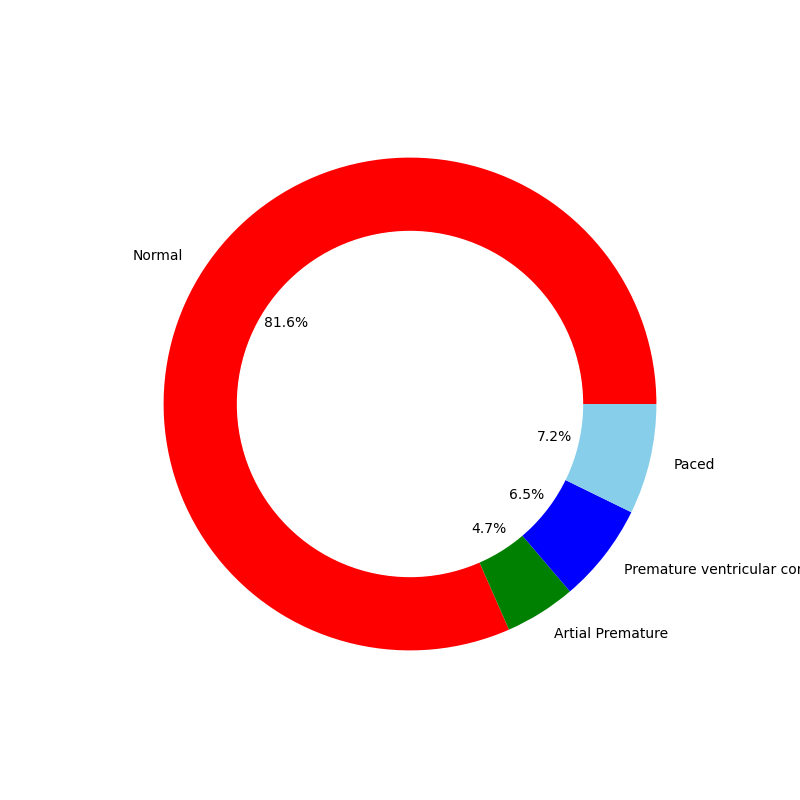

In [14]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [15]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    13589
2     1085
1      777
3     1206
Name: 187, dtype: int64


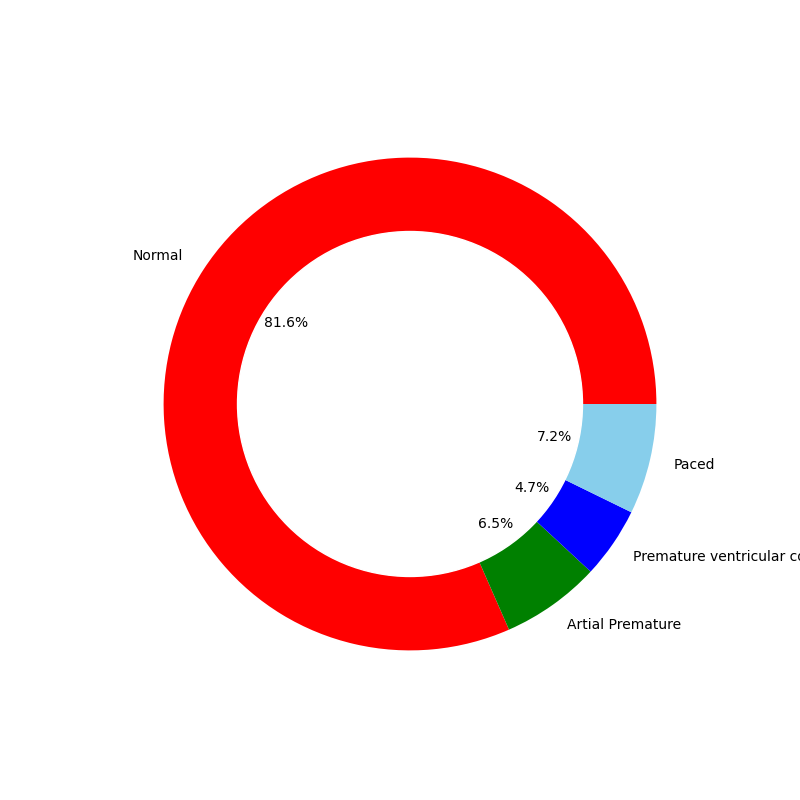

In [16]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Simple ANN

In [ ]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
save_model(model_ann, 'ANN_MITBIH_with_GAN_Data', 'keras')

In [ ]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

### CNN

In [24]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2360/2360 [==============================] - 57s 23ms/step - loss: 0.1124 - accuracy: 0.9685 - val_loss: 0.0999 - val_accuracy: 0.9717
Epoch 2/40
2360/2360 [==============================] - 55s 23ms/step - loss: 0.0630 - accuracy: 0.9816 - val_loss: 0.0692 - val_accuracy: 0.9803
Epoch 3/40
2360/2360 [==============================] - 53s 23ms/step - loss: 0.0506 - accuracy: 0.9852 - val_loss: 0.0681 - val_accuracy: 0.9796
Epoch 4/40
2360/2360 [==============================] - 50s 21ms/step - loss: 0.0411 - accuracy: 0.9877 - val_loss: 0.0586 - val_accuracy: 0.9845
Epoch 5/40
2360/2360 [==============================] - 62s 26ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.0586 - val_accuracy: 0.9828
Epoch 6/40
2360/2360 [==============================] - 59s 25ms/step - loss: 0.0296 - accuracy: 0.9905 - val_loss: 0.0562 - val_accuracy: 0.9856
Epoch 7/40
2360/2360 [==============================] - 54s 23ms/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 0.0513 -

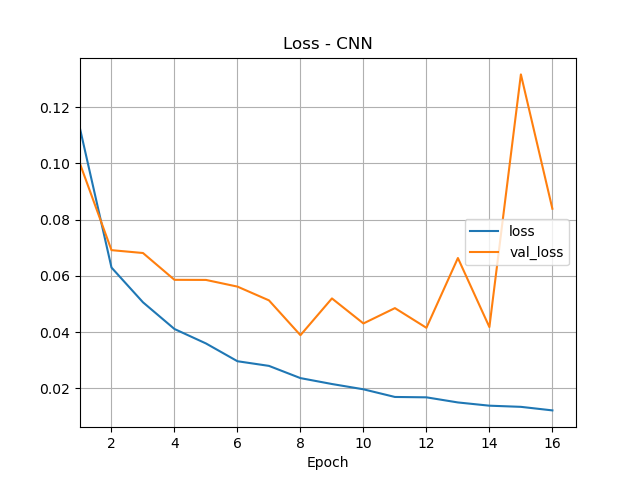

In [25]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

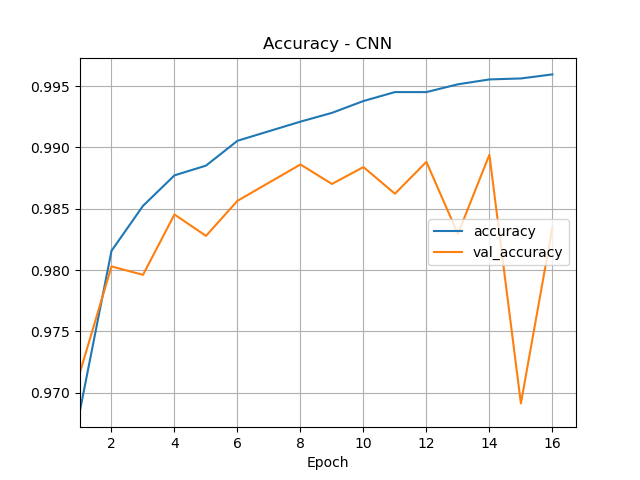

In [26]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [27]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

521/521 [==============================] - 4s 7ms/step
Accuracy of CNN:  0.9894338716455544


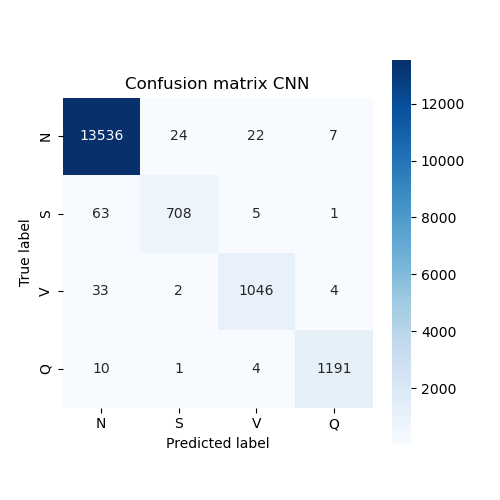

In [28]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [29]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

                                   precision    recall  f1-score   support

                           Normal     0.9922    0.9961    0.9942     13589
                 Artial Premature     0.9633    0.9112    0.9365       777
Premature ventricular contraction     0.9712    0.9641    0.9676      1085
                            Paced     0.9900    0.9876    0.9888      1206

                         accuracy                         0.9894     16657
                        macro avg     0.9792    0.9647    0.9718     16657
                     weighted avg     0.9894    0.9894    0.9894     16657



In [36]:
model_cnn.load_weights('best_cnn_5.h5')
save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras', report)